In [1]:
# %matplotlib notebook
# %matplotlib inline
import numpy as np
np.random.seed(123)
import collections, copy, pickle
import scipy.linalg
import pandas as pd
import sklearn
# import scipy.sparse
# import scipy.sparse.linalg
# import matplotlib
# import matplotlib.transforms
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
# import mpl_toolkits.mplot3d.axes3d as p3
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# from matplotlib import animation
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
# rcParams['text.usetex'] = True
from IPython.display import HTML
# from numba import jit, njit, float32, prange
# import cProfile

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [3]:
%ls

1 advanced/
1 basic/
Data-prediction-examples.ipynb
Data-prediction.ipynb
LICENSE
Makefile
ODI-2019-clean.csv
ODI-2019-csv.csv
README.md
Springer_Guidelines_for_Authors_of_Proceedings.pdf
cleanStudyDateNneighMoneyData.py
moneyPlot.png
neighPlotFull.png
neighPlotSmall.png
plotStudy.py
studyHist.png


In [4]:
# %cat ODI-2019-csv.csv

In [5]:
data = pd.read_csv('ODI-2019-clean.csv', sep=';')

In [6]:
data.describe()

,Unnamed: 0,Day,Month,Year,Neighbours,Money
count,276.000000,201.000000,201.000000,176.000000,276.000000,276.000000
mean,137.500000,15.233831,6.651741,1992.323864,39.286232,inf
std,79.818544,8.970510,3.519675,13.174117,250.892272,NaN
min,0.000000,0.000000,0.000000,1900.000000,0.000000,0.000000
25%,68.750000,8.000000,4.000000,1993.000000,2.000000,1.000000
50%,137.500000,15.000000,7.000000,1995.000000,3.000000,10.000000
75%,206.250000,23.000000,10.000000,1996.000000,6.000000,80.000000
max,275.000000,31.000000,12.000000,2030.000000,3921.000000,inf


In [7]:
data.head()

,Unnamed: 0,Timestamp,ML,IR,Stat,DB,Gender,Chocolate,Stand up,Rand,Bedtime,Good day (1),Good day (2),Stress level,Program,Day,Month,Year,Neighbours,Money
0,0,3/27/2019 10:16:11,yes,1,mu,ja,unknown,slim,no,6,23:00,sun,lecture,NaN,AI,NaN,NaN,NaN,3.0,100.0
1,1,4/1/2019 15:58:21,no,0,mu,ja,male,fat,no,7,3,DM,AI,1,AI,9.0,7.0,1992.0,1.0,0.0
2,2,4/1/2019 15:59:07,yes,1,unknown,ja,male,neither,unknown,0,0,0,0,100,CS,4.0,8.0,1995.0,0.0,0.0
3,3,4/1/2019 15:59:30,yes,1,mu,ja,male,fat,no,"1,645","0,3",Winning,Food,0,ECONOMETRICS,29.0,9.0,1993.0,2.0,42.0
4,4,4/1/2019 15:59:58,no,1,mu,ja,male,neither,no,66,20,kiss,love,100,CS,NaN,NaN,NaN,2.0,10.0


In [220]:
# {i:k for i,k in enumerate(data.keys())}

In [9]:
# data['ML'] = data['Have you taken a course on machine learning?']
# data.drop('Have you taken a course on machine learning?')
# data.keys()
# data.axes
keys = {'What programme are you in?': 'Program',
        'Have you taken a course on machine learning?': 'ML',
        'Have you taken a course on information retrieval?': 'IR',
        'Have you taken a course on statistics?': 'Stat',
        'Have you taken a course on databases?': 'DB'}
data.rename(index=str, columns=keys, inplace=True)
# df.rename(index=str, columns={"A": "a", "B": "c"})
data.keys()

Index(['Unnamed: 0', 'Timestamp', 'ML', 'IR', 'Stat', 'DB', 'Gender',
       'Chocolate', 'Stand up', 'Rand', 'Bedtime', 'Good day (1)',
       'Good day (2)', 'Stress level', 'Program', 'Day', 'Month', 'Year',
       'Neighbours', 'Money'],
      dtype='object')

In [299]:
def translate(key):
    translations = {'What programme are you in?': 'Program',
#                     'study':'Program',
#                    'Have you taken a course on machine learning?': 'ML',
#                     'Have you taken a course on information retrieval?':'IR',
#                     'Have you taken a course on statistics?':'Stat',
                    'Have you taken a course on databases?':'DB'}
    if key not in translations.keys():
        return key[-10:]
    return translations[key]

def sum_dict(d):
    return sum([sum([v for v in d[i].values()]) for i in d.keys()])

def summarize_categorical(data, k_x, k_y):
    # return the averages of each pair of categories
    categories_x = data[k_x].unique()
    categories_y = data[k_y].unique()
    # init dict
    summary = collections.defaultdict(dict)
    for x in categories_x:
        for y in categories_y:
            x = fix_label(x)
            y = fix_label(y)
            summary[x][y] = 0
    # fill dict
    assert data[k_x].size ==  data[k_y].size
    for i in range(data[k_x].size):
        x = data[k_x].get(i)
        y = data[k_y].get(i)
        x = fix_label(x)
        y = fix_label(y)
        if y not in summary[x].keys():
            summary[x][y] = 0
        summary[x][y] += 1
    n = sum_dict(summary)
    for k_x in summary.keys():
        for k_y in summary[k_x].keys():
            summary[k_x][k_y] /= n
    return summary

def fix_labels(labels):
    # in-place
    for i, v in enumerate(labels.copy()):
        if v is None:
            labels[i] = 'None'

def fix_label(x):
    max_length = 12
    x = str.title(str(x))[:max_length]
    if x is None:
        assert False
        return 'None'
    translations = {'Ja': 'Yes', 'Nee': 'No'}
    if x in translations.keys():
        return translations[x]
    return x
            
def plot_summary(summary):
    x_labels = list(summary.keys())
    y_labels = list(summary[x_labels[0]].keys())
    fix_labels(x_labels)
    fix_labels(y_labels)
    n_x = len(x_labels)
    n_y = len(y_labels)
    im = np.zeros((n_x, n_y))
    for i, k_x in enumerate(summary.keys()):
        for j, (k_y, v) in enumerate(summary[k_x].items()):
            im[i,j] = v
    # https://matplotlib.org/examples/color/colormaps_reference.html
    plt.imshow(im.T, origin='lower', vmin=0, vmax=1, cmap='terrain') # bone plasma rainbow pink cubehelix
    plt.xticks(np.arange(n_x), x_labels)
    plt.yticks(np.arange(n_y), y_labels)
    plt.colorbar()

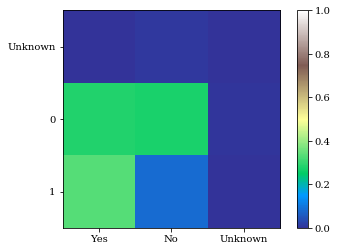

In [300]:
r = summarize_categorical(data, 'ML', 'IR')
# # r = {'A':{'e':0.9,'f':0.1}, 'B':{'e':0.1, 'f':0.1}}
plot_summary(r)

In [301]:
# categorical = ['Program','ML','IR','DB','Stat']
numerical = ['Rand', 'Bedtime', 'Year', 'Money', 'Neighbours', 'Stress level']
categorical = list(data.keys())
for label in numerical:
    categorical.remove(label)
# irrelevant
categorical.remove('Timestamp')
categorical.remove('Unnamed: 0')
categorical.remove('Month')
categorical.remove('Day')
# too many categories
categorical.remove('Good day (1)')
categorical.remove('Good day (2)')
categorical.remove('Program')

In [302]:
categorical

['ML', 'IR', 'Stat', 'DB', 'Gender', 'Chocolate', 'Stand up']

In [303]:
def plot_correlations(data, keys):
    n_items = 10
    n_keys = len(keys)    
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(18,12))
        # x
        for i_x, k_x in enumerate(keys):
            # y
            for i_y, k_y in enumerate(keys):
                if i_x < i_y:
                    plt.subplot(n_keys, n_keys, i_x + i_y * n_keys + 1)
                    if k_x in categorical:
                        categories_x = data[k_x].unique()
                        if k_y in categorical:
                            categories_y = data[k_y].unique()
                            # summarize
                            summary = summarize_categorical(data, k_x, k_y)
                            plot_summary(summary)
                        else:
                            # summarize
                            print('TODO \t', k_x, k_y)
                            pass
                    else:
                        x = getattr(data, k_x)[:n_items]
                        y = getattr(data, k_y)[:n_items]                        
                        plt.scatter(x,y, s=9, alpha=0.8)
    
                    if i_x == 0:
                        plt.ylabel(translate(k_y))

            plt.xlabel(translate(k_x))
        plt.tight_layout()

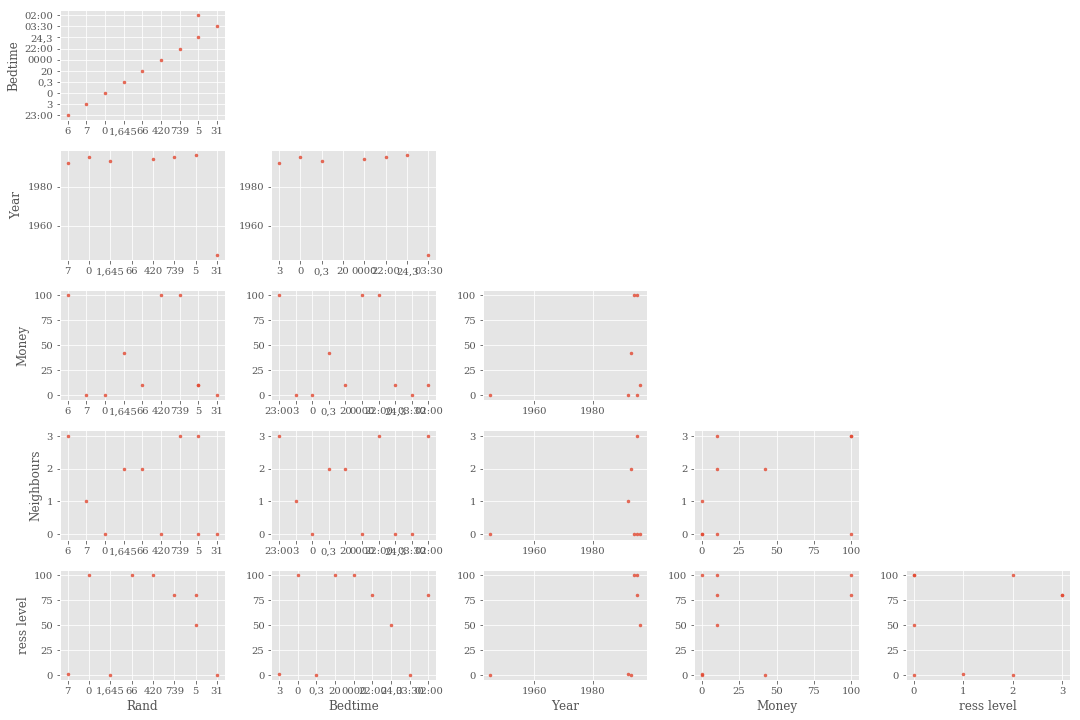

In [304]:
plot_correlations(data, numerical)

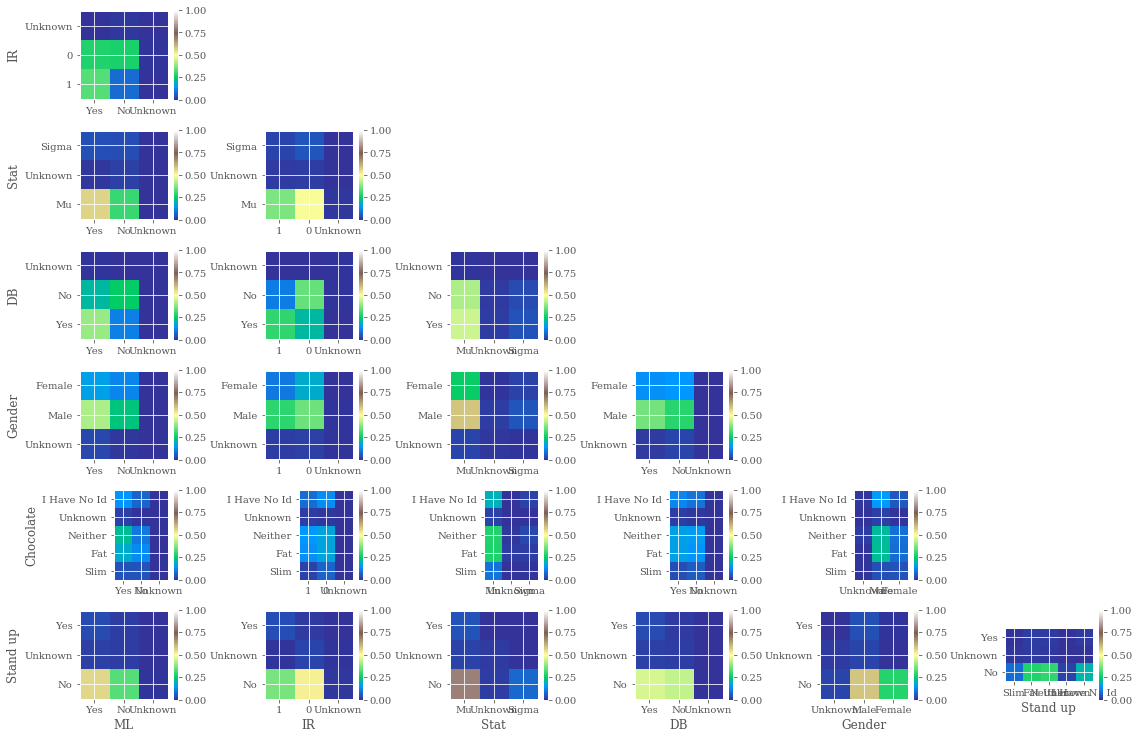

In [305]:
plot_correlations(data, categorical)